<a href="https://colab.research.google.com/github/ohilikeit/PUBG_dataset_project/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling

## 1) 모델 선언 및 학습

In [ ]:
! pip install tensorflow_addons

  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14686 sha256=7f47c5d3cc19b16bad2a33e278cee5197bf76324f3609b036ae90a449a6223e5
  Stored in directory: /root/.cache/pip/wheels/23/6a/5f/d674f3b7b4d504b03148abd675e3703ba00c31763c04a2fc20
Successfully built keras-radam


In [ ]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from sklearn.metrics import mean_absolute_error
from keras_radam import RAdam
np.random.seed(42)
tf.random.set_seed(42)

train = pd.read_csv('/content/drive/MyDrive/project1/train.csv')
train.drop(['groupId', 'matchId'], axis=1, inplace=True)
test = pd.read_csv('/content/drive/MyDrive/project1/test.csv')
test.drop(['groupId', 'matchId'], axis=1, inplace=True)

In [ ]:
# 학습 및 validation 셋 생성 
X = train.drop('winPlacePerc', axis=1)
y = train['winPlacePerc']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# 평가지표 정의
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

# custom NMAE
def custom_NMAE(y_true, y_pred):
    mapes = K.switch(K.equal(y_true, 0), y_true, K.abs(y_true - y_pred)/y_true)
    return K.mean(mapes, axis=-1)

# model 생성
def create_model():
    model = keras.Sequential(
        [       
         Dense(units=256, activation='elu', input_shape=(X.shape[1], ), kernel_initializer='he_normal'), #
         BatchNormalization(),
         Dense(units=256, activation='elu'),
         BatchNormalization(),
         Dropout(0.2),

         Dense(units=128, activation='elu'),
         BatchNormalization(),        
         Dense(units=128, activation='elu'),
         BatchNormalization(),
         Dropout(0.2),

         Dense(units=64, activation='elu'),
         BatchNormalization(),        
         Dense(units=64, activation='elu'),
         BatchNormalization(),
         Dropout(0.2),

         Dense(units=32, activation='elu'),
         Dense(units=16, activation='elu'),
         Dense(units=1, activation='elu', kernel_regularizer=regularizers.l2(0.001)) # 
        ]
    )
    return model

# https://stackoverflow.com/questions/69882263/tf-keras-callbacks-modelcheckpoint-type-error-unable-to-serialize-1-0000000656
class MyExponentialDecay(tf.keras.optimizers.schedules.ExponentialDecay):
  def __call__(self, step):
    return 1e-2 * super().__call__(step)

def call_model(batch_size, learning_rate):
        wd = MyExponentialDecay(0.001, decay_steps=14, decay_rate=0.8, staircase=True)
        optimizer = AdamW(learning_rate=learning_rate, weight_decay=wd)
        lr = ReduceLROnPlateau(monitor = 'val_custom_NMAE',
                               factor = 0.2,
                               patience = 5,
                               verbose=1,
                               mode = 'min')
        es = EarlyStopping(monitor = 'val_custom_NMAE',
                           patience = 15,
                           mode = 'min')
        cp = ModelCheckpoint(filepath = '/content/drive/MyDrive/project1/best.h5',
                             monitor = 'val_custom_NMAE',
                             verbose = 0,
                             save_best_only = True,
                             save_weights_only= True,
                             save_freq = 'epoch',
                             mode = 'auto')
        
        model = create_model()
        model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics=custom_NMAE)
        history = model.fit(X_train, y_train,
                            epochs = 300,
                            batch_size = batch_size,
                            validation_data = (X_val, y_val),
                            verbose=1,
                            callbacks = [es, cp, lr])

        return history, model

In [ ]:
history, model = call_model(batch_size = 512,
                            learning_rate = 0.001)

Epoch 1/300
1089/1089 [==============================] - 14s 10ms/step - loss: 0.0990 - custom_NMAE: 0.3576 - val_loss: 0.0703 - val_custom_NMAE: 0.2472 - lr: 0.0010
Epoch 2/300
1089/1089 [==============================] - 10s 9ms/step - loss: 0.0737 - custom_NMAE: 0.2531 - val_loss: 0.0680 - val_custom_NMAE: 0.2246 - lr: 0.0010
Epoch 3/300
1089/1089 [==============================] - 9s 9ms/step - loss: 0.0714 - custom_NMAE: 0.2450 - val_loss: 0.0695 - val_custom_NMAE: 0.2264 - lr: 0.0010
Epoch 4/300
1089/1089 [==============================] - 9s 9ms/step - loss: 0.0702 - custom_NMAE: 0.2404 - val_loss: 0.0684 - val_custom_NMAE: 0.2563 - lr: 0.0010
Epoch 5/300
1089/1089 [==============================] - 10s 9ms/step - loss: 0.0691 - custom_NMAE: 0.2365 - val_loss: 0.0668 - val_custom_NMAE: 0.2197 - lr: 0.0010
Epoch 6/300
1089/1089 [==============================] - 10s 9ms/step - loss: 0.0685 - custom_NMAE: 0.2347 - val_loss: 0.0670 - val_custom_NMAE: 0.2146 - lr: 0.0010
Epoch 7/300

## 2) 학습 곡선 그리기

In [ ]:
# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_acc(history, title=None):        # custom_NMAE(정확도) Visualization
    # summarize history for custom_NMAE
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['custom_NMAE'])        # custom_NMAE
    plt.plot(history['val_custom_NMAE'])    # validation custom_NMAE
    if title is not None:
        plt.title(title)
    plt.ylabel('custom_NMAE')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def plot_loss(history, title=None):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

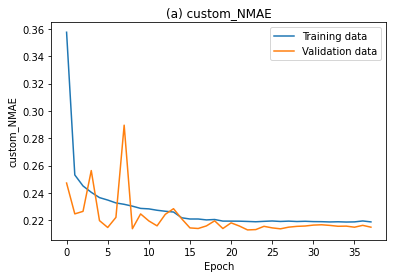

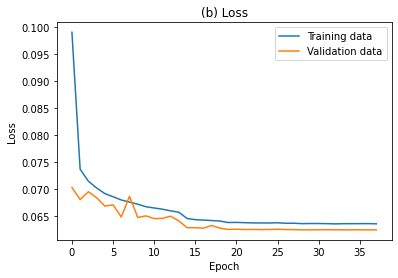

In [ ]:
plot_acc(history, '(a) custom_NMAE')  # 학습 경과에 따른 정확도 변화 추이
plt.show()
plot_loss(history, '(b) Loss')     # 학습 경과에 따른 손실값 변화 추이
plt.show()

## 3) test셋 검증

In [ ]:
# 평가지표 정의
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

# test셋으로 성능 확인
X_test = test.drop('winPlacePerc', axis=1)
y_test = test['winPlacePerc']
preds = model.predict(X_test)
y_test = y_test.values.reshape(174094,1)

nmae = NMAE(y_test, preds)
print('모델의 NMAE 값 : ', nmae)

모델의 NMAE 값 :  0.1273512034406245
